## Unsupervised Outlier Detection

1. Detect anomalies on seperate 3 seperate datasets 
    - Use different anomaly thresholds (1% -5%) 
    - And compare/verify similar dates and relationship 
    - Create a ranking/voting system for "popular" anomaly dates 
    - Additionally use Leave-one out method
2. Same but merge 3 datasets 
3. Create labels from anomalies and run supervised models
4. Optimization
5. Build a website 

https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
https://stackoverflow.com/questions/47211866/how-to-mark-specific-data-points-in-matplotlib-graph

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Import all models
import sklearn
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loci import LOCI
from pyod.models.lscp import LSCP
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.ocsvm import OCSVM
from pyod.models.sos import SOS
from pyod.models.vae import VAE
# from pyod.models.xgbod import XGBOD 

from scipy import stats
pd.options.display.max_rows = 365

/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


## Test on each Dataset Seperetly 

### Price Dataset

In [2]:
price = pd.read_csv('btc_preprocessed.csv', index_col = 0)
X = price
X.columns

Index(['close', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'CCI',
       'ichimoku_leadSpanA', 'ichimoku_leadSpanB', 'MACD', 'MACD_diff',
       'MACD_signal', 'AwesomeOscillator', 'KAMA', 'RateofChange', 'RSI_7',
       'RSI_14', 'StochasticOscillator', 'stoch_signal', 'TrueStrenghtIndex',
       'UltimateOscilator', 'williamsR', 'Accum_Distrubution', 'ForceIndex',
       'AvgTrueRange', 'BollingerHighBand', 'BHB_indicator',
       'BollingerLowBand', 'BLB_indicator', 'BC_middleBand', 'BC_percBand',
       'BCB_width', 'sma_5', 'sma_10', 'sma_20', 'sma_30', 'sma_50', 'sma_100',
       'sma_200', 'ema_5', 'ema_10', 'ema_20', 'ema_30', 'ema_50', 'ema_100',
       'ema_200', 'vwma', 'hull_Moving', 'Mkt_Cap'],
      dtype='object')

## Different models return 0 or NAN value depending on the dataset 
    - So I choose 5 models that work on all (for now)

In [3]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
for fraction in outliers_fraction:
    random_state = np.random.RandomState(123) # set random state
    
    # Define 10 outlier detection tools to be compared
    classifiers = {#'ABOD': ABOD(contamination = fraction),
                  #'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
                  'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
                  'HBOS': HBOS(contamination=fraction),
                  'IF': IForest(contamination=fraction,random_state=random_state),
                  'KNN': KNN(contamination=fraction),
                  'Average KNN': KNN(method='mean',contamination=fraction),
                  #'OCSVM' : OCSVM(contamination=fraction),
                  #'SOS' : SOS(contamination=fraction)
                   #'LOF': LOF(n_neighbors=35, contamination = fraction),
                  # 'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
                  #'VAE' : VAE(contamination=fraction, random_state=random_state),
                  #'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state)
                  }
    
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  1 INLIERS :  364 KNN
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.02
OUTLIERS :  7 INLIERS :  358 FB
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 HBOS
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 IF
Outlier fraction:  0.02
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.02
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 FB
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 HBOS
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 IF
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 KNN
Outlier fraction:  0.03
OUTLIERS :  7 INLIERS :  358 Average KNN
Outlier fraction:  0.04
OUTLIERS :  14 INLIERS :  351 FB
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 HBOS
Outl

In [4]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
print('Nbr of lists',len(df_outliers), '(5 outlier fractions and 9 models)')

Time to run:  6.00675892829895 s
Nbr of lists 25 (5 outlier fractions and 9 models)


## Get unique dates per outlier fraction iteration across models
- Change if number of models change 

In [5]:
frac_oo1 = df_outliers[0:5]
frac_oo2 = df_outliers[5:10]
frac_oo3 = df_outliers[10:15]
frac_oo4 = df_outliers[15:20]
frac_oo5 = df_outliers[20:]

# subset data so we only get dates where models identified them as outliers
def outlier_subset_function(outliers_lst):
# convert lists into df and transpose it
    btc_outliers = np.transpose(pd.DataFrame(outliers_lst))#.reset_index()
    
    outlier_dates = [] # this stores outlier dates
    #lenght = len(outlier_dates)
    for col in btc_outliers.columns:
        outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
        outlier_dates.append(outliers.index.tolist()) # append the string/date 
        
        #lenght2 = len(outlier_dates)
        #nbr_dates = 
    return outlier_dates

In [6]:
# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

## Anomaly Probability Ranking
- how many fractions (AnomalyCount_Fraction) and models (AnomalyCount_Models) identified the date as an outlier
- count_weight_outliers list number **UPDATED** based on the number of models in dataset

In [7]:
def count_weight_outliers(outlier_dates): 
    join =outlier_dates[0] + outlier_dates[1] + outlier_dates[2] + outlier_dates[3] + outlier_dates[4]# +\
    #outlier_dates[5]+outlier_dates[6]+outlier_dates[7]
    (unique, counts) = np.unique(join, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    frequencies_df = pd.DataFrame(frequencies)
    frequencies_df.columns = ['Date','Rank']
    frequencies_df.Rank = frequencies_df.Rank.astype(int)
    frequencies_df['Weight'] = frequencies_df['Rank']/5 # ALTER THIS if nbr models changes
    frequencies_df = frequencies_df.sort_values(by='Rank', ascending = False)
    return frequencies_df

# all fraction anomalous dates found merged 
def date_ranking(df1, df2, df3, df4, df5):
    # concat all unique dates 
    concat = pd.concat([count_weight_outliers(df1),count_weight_outliers(df2),
            count_weight_outliers(df3),count_weight_outliers(df4), count_weight_outliers(df5)], 
            axis = 0)
    
    # how many times was a date selected 
    anomalyCount_Fractions = pd.DataFrame(concat.Date.value_counts()).reset_index()
    anomalyCount_Fractions.columns = ['Date','AnomalyCount_Fractions']
 
    # sum votes over all 
    sum_votes = concat.Rank.sum()
    
    # sum of nbr of models that selected a date as an anomaly 
    vote_count = pd.DataFrame(concat.groupby("Date")['Rank'].agg('sum')).reset_index()
    # merge it with anomalyCount_Fractions df so that dates match 
    merged_inner = pd.merge(left=anomalyCount_Fractions, right=vote_count, on='Date')
    merged_inner.columns = ['Date','AnomalyCount_Fractions','AnomalyCount_Models']
    # sum models per dates / total anomaly votes
    merged_inner['weight_models'] = merged_inner.AnomalyCount_Models/sum_votes
    return merged_inner

In [8]:
price_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(price_anomalies.Date.unique()))
price_anomalies

Unique Anomaly Dates:  43


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-01-03,5,13,0.052
1,2018-01-02,5,18,0.072
2,2018-01-06,5,15,0.060
3,2018-07-24,5,5,0.020
4,2018-07-18,5,5,0.020
5,2018-07-17,5,5,0.020
6,2018-07-19,5,5,0.020
7,2018-01-05,5,14,0.056
8,2018-01-07,5,19,0.076
9,2018-01-16,5,14,0.056


In [9]:
def dates_per_fraction(l1,l2,l3,l4,l5):
    d1 = pd.concat([count_weight_outliers(l1),count_weight_outliers(l2),count_weight_outliers(l3),
                    count_weight_outliers(l4),count_weight_outliers(l5)],axis=1)
    d1.columns = ['001','Count1','W1','002','Count2','W2','003','Count3','W3','004','Count4','W4','005',
                'Count5','W5']
    d01 = d1['001'].value_counts()
    d02 = d1['002'].value_counts()
    d03 = d1['003'].value_counts()
    d04 = d1['004'].value_counts()
    d05 = d1['005'].value_counts()
    l = pd.concat([d01,d02,d03,d04,d05],axis=1, sort=True)
    l = l.groupby(l.index)['001','002','003','004','005'].agg('count')
    print('Outlier fraction 0.01 unique dates: ',l['001'].sum())
    print('Outlier fraction 0.02 unique dates: ',l['002'].sum())
    print('Outlier fraction 0.03 unique dates: ',l['003'].sum())
    print('Outlier fraction 0.04 unique dates: ',l['004'].sum())
    print('Outlier fraction 0.05 unique dates: ',l['005'].sum())
    return l

dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  10
Outlier fraction 0.02 unique dates:  17
Outlier fraction 0.03 unique dates:  24
Outlier fraction 0.04 unique dates:  33
Outlier fraction 0.05 unique dates:  43


,001,002,003,004,005
2018-01-01,0,0,1,1,1
2018-01-02,1,1,1,1,1
2018-01-03,1,1,1,1,1
2018-01-04,0,1,1,1,1
2018-01-05,1,1,1,1,1
2018-01-06,1,1,1,1,1
2018-01-07,1,1,1,1,1
2018-01-08,0,1,1,1,1
2018-01-09,0,0,1,1,1
2018-01-10,0,0,1,1,1


In [10]:
# save ranking table
#frequencies_df_price = frequencies_df
# save the outliers lists uniquely for later
prices_df = df_outliers
# probability lists
prices_proba = proba_lst
# rank lists
prices_rank_lst = predict_rank_lst

## Example of Probabilities Output 
- I think it's similar to predict() where I get labels not ratios (based on threshold it labels?)
- predict_proba(): Predict the probability of a sample being outlier using the fitted detector.
- simply use Min-max conversion to linearly transform the outlier scores into the range of [0,1]. 
- Description of labeling formula vs probabilty: https://pyod.readthedocs.io/en/latest/_modules/pyod/models/base.html#BaseDetector.predict

In [130]:
import sys
np.set_printoptions(threshold=100)
prices_proba[0][:50]

array([[0.92062602, 0.07937398],
       [0.05501771, 0.94498229],
       [0.15048567, 0.84951433],
       [0.26563163, 0.73436837],
       [0.15884559, 0.84115441],
       [0.2553066 , 0.7446934 ],
       [0.41725203, 0.58274797],
       [0.60143619, 0.39856381],
       [0.71358273, 0.28641727],
       [0.69717411, 0.30282589],
       [0.96910424, 0.03089576],
       [0.95910906, 0.04089094],
       [0.94386569, 0.05613431],
       [0.96833857, 0.03166143],
       [0.96386841, 0.03613159],
       [0.84734548, 0.15265452],
       [0.87108139, 0.12891861],
       [0.89828945, 0.10171055],
       [0.92638605, 0.07361395],
       [0.9581257 , 0.0418743 ],
       [0.94497961, 0.05502039],
       [0.93360854, 0.06639146],
       [0.94767544, 0.05232456],
       [0.96099536, 0.03900464],
       [0.96110326, 0.03889674],
       [0.96661208, 0.03338792],
       [0.97399046, 0.02600954],
       [0.96575401, 0.03424599],
       [0.97032312, 0.02967688],
       [0.95866925, 0.04133075],
       [0.

## Blockhain Test (need to add some feature engineering)
- note no feature engineering added to this dataset

In [11]:
block = pd.read_csv('blockchain18.csv', index_col = 0)
X = block

In [12]:
X.columns

Index(['active_addresses', 'average_transaction_value', 'block_height',
       'block_size', 'block_time', 'current_supply', 'difficulty', 'hashrate',
       'large_transaction_count', 'new_addresses', 'transaction_count',
       'transaction_count_all_time', 'unique_addresses_all_time',
       'zero_balance_addresses_all_time'],
      dtype='object')

In [13]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
for fraction in outliers_fraction:
    random_state = np.random.RandomState(123) # set random state

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  16 INLIERS :  349 FB
Outlier fraction:  0.01
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.01
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.01
OUTLIERS :  19 INLIERS :  346 KNN
Outlier fraction:  0.01
OUTLIERS :  17 INLIERS :  348 Average KNN
Outlier fraction:  0.02
OUTLIERS :  16 INLIERS :  349 FB
Outlier fraction:  0.02
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.02
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.02
OUTLIERS :  19 INLIERS :  346 KNN
Outlier fraction:  0.02
OUTLIERS :  17 INLIERS :  348 Average KNN
Outlier fraction:  0.03
OUTLIERS :  16 INLIERS :  349 FB
Outlier fraction:  0.03
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.03
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.03
OUTLIERS :  19 INLIERS :  346 KNN
Outlier fraction:  0.03
OUTLIERS :  17 INLIERS :  348 Average KNN
Outlier fraction:  0.04
OUTLIERS :  16 INLIERS :  349 FB
Outlier fraction:  0.04
OUTLIERS :  19 INLIERS :  34

In [14]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 7 models)
len(df_outliers)

Time to run:  3.762877941131592 s


25

In [15]:
frac_oo1 = df_outliers[0:5]
frac_oo2 = df_outliers[5:10]
frac_oo3 = df_outliers[10:15]
frac_oo4 = df_outliers[15:20]
frac_oo5 = df_outliers[20:]
# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

- updated the function list lenght above (because here we have less models 
- also with the number to divide to get weight

In [16]:
block_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(block_anomalies.Date.unique()))
block_anomalies

Unique Anomaly Dates:  70


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-06-22,5,5,0.011111
1,2018-02-11,5,5,0.011111
2,2018-02-18,5,5,0.011111
3,2018-10-16,5,5,0.011111
4,2018-01-17,5,8,0.017778
5,2018-10-07,5,5,0.011111
6,2018-02-20,5,10,0.022222
7,2018-10-10,5,5,0.011111
8,2018-04-25,5,5,0.011111
9,2018-10-04,5,15,0.033333


In [17]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  65
Outlier fraction 0.02 unique dates:  66
Outlier fraction 0.03 unique dates:  67
Outlier fraction 0.04 unique dates:  65
Outlier fraction 0.05 unique dates:  66


,001,002,003,004,005
2018-01-01,1,1,1,1,1
2018-01-02,1,1,1,1,1
2018-01-03,1,1,1,1,1
2018-01-04,1,1,1,1,1
2018-01-05,1,1,1,1,1
2018-01-06,1,1,1,1,1
2018-01-07,1,1,1,1,1
2018-01-08,1,1,1,1,1
2018-01-09,1,1,1,1,1
2018-01-10,1,1,1,1,1


In [18]:
# save the outliers lists uniquely for later
block_df = df_outliers
# probability lists
block_proba = proba_lst
# rank lists
block_rank = predict_rank_lst

# Social Dataset Test 

In [19]:
social = pd.read_csv("social18.csv", index_col = 0)
X = social

In [20]:
X.columns

Index(['comments', 'posts', 'followers', 'points', 'overview_page_views',
       'analysis_page_views', 'markets_page_views', 'charts_page_views',
       'trades_page_views', 'forum_page_views', 'influence_page_views',
       'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
       'twitter_following', 'twitter_lists', 'twitter_favourites',
       'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
       'reddit_posts_per_hour', 'reddit_posts_per_day',
       'reddit_comments_per_hour', 'reddit_comments_per_day',
       'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
       'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
       'code_repo_open_issues', 'code_repo_closed_issues',
       'code_repo_contributors'],
      dtype='object')

In [21]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
for fraction in outliers_fraction:
    random_state = np.random.RandomState(123) # set random state

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  15 INLIERS :  350 FB
Outlier fraction:  0.01
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.01
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.01
OUTLIERS :  11 INLIERS :  354 KNN
Outlier fraction:  0.01
OUTLIERS :  5 INLIERS :  360 Average KNN
Outlier fraction:  0.02
OUTLIERS :  12 INLIERS :  353 FB
Outlier fraction:  0.02
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.02
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.02
OUTLIERS :  11 INLIERS :  354 KNN
Outlier fraction:  0.02
OUTLIERS :  5 INLIERS :  360 Average KNN
Outlier fraction:  0.03
OUTLIERS :  14 INLIERS :  351 FB
Outlier fraction:  0.03
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.03
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 KNN
Outlier fraction:  0.03
OUTLIERS :  5 INLIERS :  360 Average KNN
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 FB
Outlier fraction:  0.04
OUTLIERS :  19 INLIERS :  346 H

In [22]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
len(df_outliers)

Time to run:  4.096791982650757 s


25

In [23]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:5]
frac_oo2 = df_outliers[5:10]
frac_oo3 = df_outliers[10:15]
frac_oo4 = df_outliers[15:20]
frac_oo5 = df_outliers[20:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

In [24]:
social_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(social_anomalies.Date.unique()))
social_anomalies

Unique Anomaly Dates:  42


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-02-04,5,10,0.029326
1,2018-04-08,5,17,0.049853
2,2018-04-12,5,5,0.014663
3,2018-02-07,5,5,0.014663
4,2018-01-23,5,5,0.014663
5,2018-01-08,5,10,0.029326
6,2018-01-15,5,6,0.017595
7,2018-02-21,5,5,0.014663
8,2018-01-07,5,10,0.029326
9,2018-01-09,5,10,0.029326


In [25]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  42
Outlier fraction 0.02 unique dates:  38
Outlier fraction 0.03 unique dates:  38
Outlier fraction 0.04 unique dates:  41
Outlier fraction 0.05 unique dates:  42


,001,002,003,004,005
2018-01-01,1,1,1,1,1
2018-01-02,1,1,1,1,1
2018-01-03,1,1,1,1,1
2018-01-04,1,1,1,1,1
2018-01-05,1,1,1,1,1
2018-01-06,1,1,1,1,1
2018-01-07,1,1,1,1,1
2018-01-08,1,1,1,1,1
2018-01-09,1,1,1,1,1
2018-01-10,1,1,1,1,1


In [26]:
# save the outliers lists uniquely for later
block_df_s = df_outliers
# probability lists
block_proba_s = proba_lst
# rank lists
block_rank_s = predict_rank_lst

## 3 Dataset Common anomaly dates 

In [27]:
three_dataset_anomalies = pd.merge(pd.merge(price_anomalies,block_anomalies,on='Date'),social_anomalies,on='Date')
print('Nbr of common date anomalies across three datasets: ',len(three_dataset_anomalies.Date))
three_dataset_anomalies

Nbr of common date anomalies across three datasets:  17


,Date,AnomalyCount_Fractions_x,AnomalyCount_Models_x,weight_models_x,AnomalyCount_Fractions_y,AnomalyCount_Models_y,weight_models_y,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-01-03,5,13,0.052,5,5,0.011111,5,15,0.043988
1,2018-01-02,5,18,0.072,5,5,0.011111,5,15,0.043988
2,2018-01-06,5,15,0.060,5,5,0.011111,5,10,0.029326
3,2018-01-05,5,14,0.056,5,5,0.011111,5,8,0.023460
4,2018-01-07,5,19,0.076,5,5,0.011111,5,10,0.029326
5,2018-01-16,5,14,0.056,5,9,0.020000,5,10,0.029326
6,2018-01-17,4,11,0.044,5,8,0.017778,5,10,0.029326
7,2018-01-04,4,14,0.056,5,5,0.011111,5,10,0.029326
8,2018-01-08,4,15,0.060,5,5,0.011111,5,10,0.029326
9,2018-01-09,3,10,0.040,5,5,0.011111,5,10,0.029326


# Anomaly Detection on all 3 datasets together

In [28]:
merged_df = pd.concat([price,block,social], axis = 1)
X = merged_df
merged_df.shape

(365, 96)

In [29]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
for fraction in outliers_fraction:
    random_state = np.random.RandomState(123) # set random state

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  12 INLIERS :  353 FB
Outlier fraction:  0.01
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.01
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.01
OUTLIERS :  13 INLIERS :  352 KNN
Outlier fraction:  0.01
OUTLIERS :  9 INLIERS :  356 Average KNN
Outlier fraction:  0.02
OUTLIERS :  9 INLIERS :  356 FB
Outlier fraction:  0.02
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.02
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.02
OUTLIERS :  13 INLIERS :  352 KNN
Outlier fraction:  0.02
OUTLIERS :  9 INLIERS :  356 Average KNN
Outlier fraction:  0.03
OUTLIERS :  18 INLIERS :  347 FB
Outlier fraction:  0.03
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.03
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.03
OUTLIERS :  13 INLIERS :  352 KNN
Outlier fraction:  0.03
OUTLIERS :  9 INLIERS :  356 Average KNN
Outlier fraction:  0.04
OUTLIERS :  10 INLIERS :  355 FB
Outlier fraction:  0.04
OUTLIERS :  19 INLIERS :  346 HB

In [30]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
print(len(df_outliers))

Time to run:  5.9606053829193115 s
25


In [31]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:5]
frac_oo2 = df_outliers[5:10]
frac_oo3 = df_outliers[10:15]
frac_oo4 = df_outliers[15:20]
frac_oo5 = df_outliers[20:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

In [32]:
allthree_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(allthree_anomalies.Date.unique()))
allthree_anomalies

Unique Anomaly Dates:  54


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-02-05,5,20,0.054496
1,2018-11-19,5,5,0.013624
2,2018-01-07,5,18,0.049046
3,2018-07-24,5,5,0.013624
4,2018-01-04,5,19,0.051771
5,2018-10-16,5,5,0.013624
6,2018-01-17,5,15,0.040872
7,2018-01-16,5,20,0.054496
8,2018-08-28,5,5,0.013624
9,2018-01-09,5,16,0.043597


In [112]:
# getting all close price values 
close_anomalies = []
for dates in allthree_anomalies['Date']:
    # get close price 
    d = X.loc[str(dates),'close']
    close_anomalies.append(d)
close_anomalies = pd.Series(close_anomalies)
table_dates = allthree_anomalies['Date']
anomalies = pd.concat([table_dates,close_anomalies], axis = 1)
anomalies.columns = ['Date','Close']
anomalies.Date = pd.to_datetime(anomalies.Date)

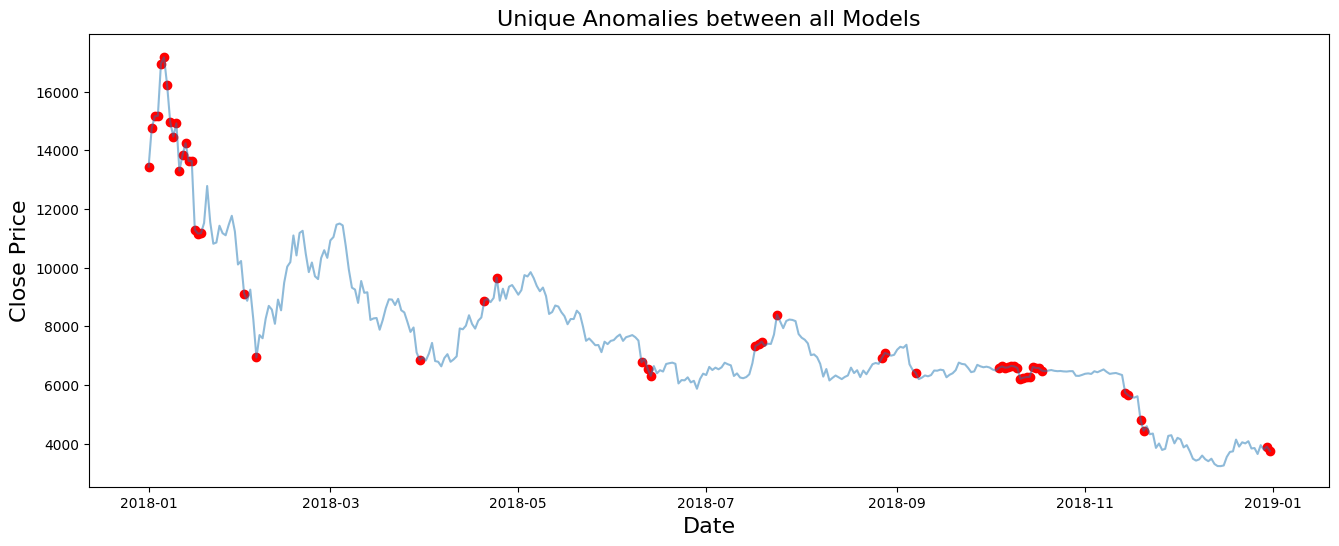

In [115]:
# filter for same dates 
import matplotlib.pyplot as plt
common = \
    set.intersection(set(X.index), set(anomalies.Date))
filter1 = X[X.index.isin(common)]
filter1 = filter1[['close']]

# Converting the index as date
X.index = pd.to_datetime(X.index)
# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# scatter plot with matplotlib in Python
plt.plot(X.index, X.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

plt.scatter(filter1.index, filter1.close, color="red")
plt.show()

- it would be interesting to see if there are any "signals" for data identified as an anomaly right before price **spikes** or **drops**
- I would say major anomalies were flagged but some are still missing (visially) granted only 5 models were used

## To Be Continued 

## Probability

In [ ]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
#outlier_proba

## Outlier Date Counts

In [ ]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
#btc_outliers

## Predict Rank Scores

In [ ]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df.index = merged_df.index
#pred_rank_df

# Intersection Between Merge and different datasets

In [ ]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [ ]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

## CBLOF intersection dates across tests (arbitrary model check)

In [ ]:
[x for x in three[3] if x in prices_df[3]]

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [ ]:
# prices and blockchain
intersection(prices_df[1], block_df[1])

In [ ]:
intersection(prices_df[1], social_df[1])

In [ ]:
dates_knn = list(btc_outliers[btc_outliers['K Nearest Neighbors (KNN)']==1].index)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[dates_knn,0],X_reduce[dates_knn,1], X_reduce[dates_knn,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [ ]:
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN(contamination=0.05)
clf.fit(X.values)

In [ ]:
# predict raw anomaly score 
# np.set_printoptions(precision=None)

#clf.decision_scores_

scores_pred = clf.decision_function(X) 
print(scores_pred.shape)

In [ ]:
# get the prediction on the test data
y_pred = clf.predict(X)  # outlier labels (0 or 1)
print(y_pred.shape)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 * 0.05)
threshold